Jawaban 3A:


*   Generative Adversarial Network (GAN) terdiri dari 2 bagian, Generator dan Discriminator.
*   Generator: Input yang akan diterima oleh generator adalah noise acak yang biasanya adalah vektor berdimensi tinggi, kemudian noise ini akan melalui beberapa neural network dan akan diubah menjadi image fake atau palsu yang menyerupai image asli.

*   Discriminator: Input yang akan diterima oleh discriminator adalah image asli dan juga image fake yang sudah di generate oleh generator, lalu discriminator akan mengklasifikasi dan memberikan output mana image yang asli dan mana yang fake.

*  Tujuan dari GAN adalah generator dapat menghasilkan image yang sangat mirip denga yang asli sehingga discriminator tidak bisa membedakannya dengan yang asli.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


IMPORT DATA

In [ ]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [ ]:
x_train, y_train = load_mnist('/content/drive/MyDrive/uas_dl', kind='train')
x_test, y_test = load_mnist('/content/drive/MyDrive/uas_dl', kind='t10k')

Filter Data menjadi 2 class saja sesuai dengan class yang sudah dibagi berdasarkan NIM dan Gender (Coat and Sandal)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train_filter = np.isin(y_train, [4, 5])
x_train_filtered = x_train[train_filter]
y_train_filtered = y_train[train_filter]

test_filter = np.isin(y_test, [4, 5])
x_test_filtered = x_test[test_filter]
y_test_filtered = y_test[test_filter]

y_train_filtered = np.where(y_train_filtered == 4, 0, 1)
y_test_filtered = np.where(y_test_filtered == 4, 0, 1)

print(np.unique(y_train_filtered))
print(np.unique(y_test_filtered))

[0 1]
[0 1]


Melihat jumlah data Train dan Test

In [ ]:
print('Training data shapes: X=%s, y=%s' % (x_train_filtered.shape, y_train_filtered.shape))
print('Testing data shapes: X=%s, y=%s' % (x_test_filtered.shape, y_test_filtered.shape))

Training data shapes: X=(12000, 784), y=(12000,)
Testing data shapes: X=(2000, 784), y=(2000,)


Normalize image dah mengubah bentuk menjadi 28x28 sesuai besar image.

In [ ]:
xtrain = [image/255.0 for image in x_train_filtered]
xtest = [image/255.0 for image in x_test_filtered]

xtrain = np.reshape(xtrain, (12000, 28, 28, 1))
xtest = np.reshape(xtest, (2000, 28, 28, 1))

print('Training data shapes: X=%s, y=%s' % (xtrain.shape, y_train_filtered.shape))
print('Testing data shapes: X=%s, y=%s' % (xtest.shape, y_test_filtered.shape))

Training data shapes: X=(12000, 28, 28, 1), y=(12000,)
Testing data shapes: X=(2000, 28, 28, 1), y=(2000,)


Melihat contoh image dimana image terdiri dari hanya Coat dan juga Sandal yang beragam.

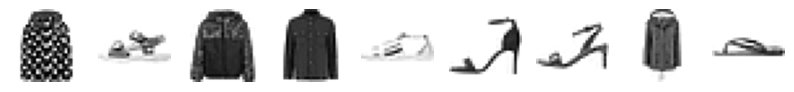

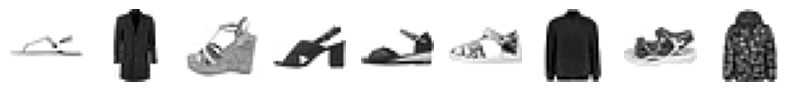

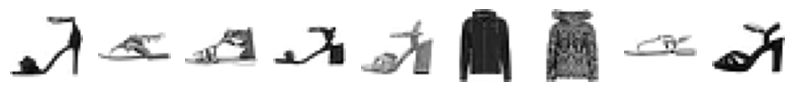

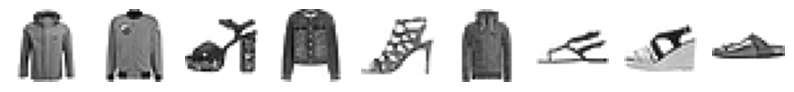

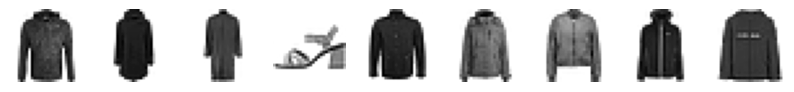

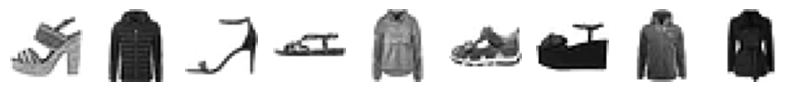

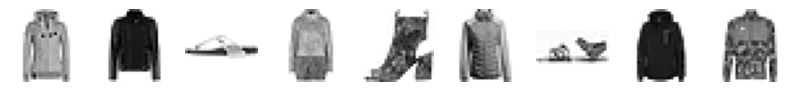

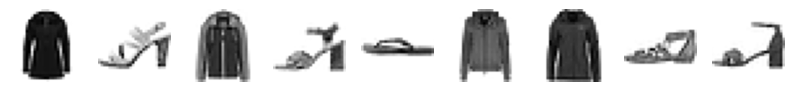

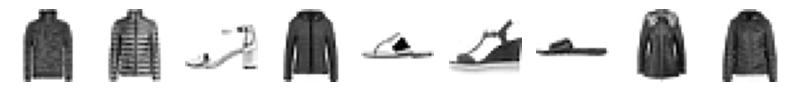

In [ ]:
for k in range(9):
    plt.figure(figsize=(10, 10))
    for j in range(9):
        i = np.random.randint(0, xtrain.shape[0])
        plt.subplot(990 + 1 + j)
        plt.imshow(xtrain[i], cmap='gray_r')
        plt.axis('off')
    plt.show()



*   Membuat model untuk Generator:
*   Pertama-tama ada input layer yang menerima single integer yang merepresentasikan Class yang ada (Coat atau Sandal / 0 atau 1). Lalu label class di embed dengan vector size 100 yang berupa noise dan di Flatten menjadi 1D array. Selanjutnya model menerima input noise dengan size vector 100 yang akan digunakan untuk mengenerate image. Lalu keduanya di concate untuk menjadi input dari model Generator.

*   Lalu untuk GAN nya sendiri memiliki 5 layer. 5 Layer tersebut adalah fully connected layer. Layer pertama dengan 128 units dan activation relu, layer kedua dengan 256 units dan activation relu, layer ketiga dengan 512 units dan activation relu, layer keempat dengan 1024 units dan activation relu dan layer terakhir dengan 28 kali 28 (image size) dengan activation tanh. Lalu image di  reshape ke bentuk aslinya yaitu 28 kali 28 kali 1.

*   Selanjutnya model di define dengan meminta input size noise dan juga size label dengan output generated image.






In [ ]:
from tensorflow.keras import layers, models

label_input = layers.Input(shape=(1,))
label_embedding = layers.Embedding(input_dim = 2, output_dim = 100)(label_input)
label_embedding = layers.Flatten()(label_embedding)
random_input = layers.Input(100)
gen_input = layers.Concatenate()([random_input, label_embedding])

x = layers.Dense(128, activation='relu')(gen_input)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(28 * 28, activation='tanh')(x)
generated_image = layers.Reshape((28, 28, 1))(x)

generator_network = models.Model(inputs = [random_input, label_input], outputs = generated_image)
generator_network.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_40 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_14 (Embedding)    (None, 1, 100)               200       ['input_40[0][0]']            
                                                                                                  
 input_41 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 flatten_22 (Flatten)        (None, 100)                  0         ['embedding_14[0][0]']        
                                                                                           



*   Discriminator Model:
*   Pertama-tama ada input layer yang menerima image dari Generator dengan size 28, 28, 1 dan single integer yang merepresentasikan Class yang ada (Coat atau Sandal / 0 atau 1). Lalu label class di embed dengan dense vector size 28 kali 28 yang di flatten menjadi 1D array dan di reshape menjadi 28 kali 28 kali 1. Lalu keduanya di concate untuk menjadi 1.

*   Selanjutnya sebelum masuk ke dense layer, input yang sudah di concate di flatten menajadi 1D array. Lalu ada 4 layer dengan fully connected layer dengan jumlah unit 512, 1024, 1024 dan 512 dan semuanya menggunakan activation relu. Dan yang terakhir ada fully connected layer dengan 1 unit dan activation sigmoid yang outputnya antara 0 atau 1 yang merepresentasikan hasil dari input image.

*  Selanjutnya model discriminator di define dengan input size image dan label dengan output dari fully connected layer yang memiliki 1 unit.





In [ ]:
from tensorflow.keras import layers, models

image_input_2 = layers.Input(shape=(28, 28, 1))
label_input_2 = layers.Input(shape=(1,))

label_embedding_2 = layers.Embedding(input_dim=2, output_dim=28*28)(label_input_2)
label_embedding_2 = layers.Flatten()(label_embedding_2)
label_embedding_2 = layers.Reshape((28, 28, 1))(label_embedding_2)

concatenated_input = layers.Concatenate(axis=-1)([image_input_2, label_embedding_2])

x = layers.Flatten()(concatenated_input)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
real_vs_fake_output = layers.Dense(1, activation='sigmoid')(x)

discriminator_network = models.Model(inputs=[image_input_2, label_input_2], outputs=real_vs_fake_output)

discriminator_network.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_39 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_13 (Embedding)    (None, 1, 784)               1568      ['input_39[0][0]']            
                                                                                                  
 flatten_20 (Flatten)        (None, 784)                  0         ['embedding_13[0][0]']        
                                                                                                  
 input_38 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                           

Selanjutnya model discriminator di compile menggunakan loss function yaitu binary_crossentropy karena hanya ada 2 kelas dan optimizer menggunakan adam dengan learning rate 0.0002 dan beta_1 0.5 dan yang terakhir metrics accuracy.

In [ ]:
from tensorflow.keras import optimizers
adam_optimizer = optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_network.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

model Discriminator di set false untuk trainable agar weight dari discriminator tidak akan diupdate ketika di train karena yang ingin di update hanya dari yang Generator saja. g output dan d output merupakan output dari masing masing model dengan menerima input size vector noise dan label input untuk generator dan hasil dari generator output dan label input untuk d_output. Lalu model GAN di define dengan menerima input size vector noise dan label input dengan output nya d_output.

In [ ]:
discriminator_network.trainable = False

g_output = generator_network([random_input, label_input])
d_output = discriminator_network([g_output, label_input])

gan_model = models.Model(inputs=[random_input, label_input], outputs=d_output)
gan_model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_37 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 input_36 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 model_18 (Functional)       (None, 28, 28, 1)            1519448   ['input_37[0][0]',            
                                                                     'input_36[0][0]']            
                                                                                                  
 model_19 (Functional)       (None, 1)                    2905121   ['model_18[0][0]',     

GAN model di compile dengan loss function binary crossentropy karena class berjumlah binary dan optimizer adam.

In [ ]:
gan_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer)



*   indices adalah list untuk training dataset yang digunakan untuk training
*   function get random noise adalah untuk mengenerate beberapa random noise vector dimana batch size adalah jumlah noice vector dan noise size adalah dimensi noise.
*  function get random labels untuk mengenerate random labels
*  function get fake dan real sample adalah untuk mengenerate fake image menggunakan model generator dengan parameter model generatornya, batch size (jumlah fake sample) dan noise size. Dan untuk real sample diambil dari dataset dengan labelnya.
*  function show generator result akan dipakai untuk melihat hasil dari image yang di generate oleh model.



In [ ]:
indices = [i for i in range(len(xtrain))]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size * noise_size)
    random_noise_batch = np.reshape(random_values, (batch_size, noise_size))
    return random_noise_batch

def get_random_labels(batch_size):
    return np.random.randint(0, 2, (batch_size, 1))

def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batch = get_random_noise(batch_size, noise_size)
    random_labels = get_random_labels(batch_size)
    fake_samples = generator_network.predict_on_batch([random_noise_batch, random_labels])
    return fake_samples, random_labels

def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_images = xtrain[np.array(random_indices), :]
    real_labels = y_train_filtered[np.array(random_indices)]
    real_images = np.reshape(real_images, (batch_size, 28, 28, 1))
    real_labels = np.reshape(real_labels, (batch_size, 1))
    return real_images, real_labels

def show_generator_results(generator_network):
    for k in range(9):
        plt.figure(figsize=(7, 7))
        fake_samples, _ = get_fake_samples(generator_network, 9, noise_size)
        for j in range(9):
            plt.subplot(990 + 1 + j)
            plt.imshow(fake_samples[j, :, :, -1], cmap='gray_r')
            plt.axis('off')
        plt.show()
    return



*   Untuk train model, epoch yang digunakan adalah 150, dengan batch size 64 dan steps 187 (jumlah data train/batch size 12000 / 64) dan noise size 100. losses_d untuk menyimpan loss dari discriminator dan loss g untuk menimpan loss dari generator
*   Loop pertama untuk mengiterate epoch dan loop di dalamnya untuk mengiterate steps per epoch.
*   Di dalam loop, generator akan mengenerate image fake dan juga labelnya lalu mengambil data real image dan labelnya dan digabung untuk digunakan untuk training di discriminator.
*   Selanjutnya Discriminator akan di train menggunakan real dan fake image yang sudah di gabung dan loss dari discriminator akan di catat di loss_d
*   Selanjutnya generator akan di train via GAN model untuk mengelabui discriminator dan loss dari generator akan di catat di loss_g
*   Selanjutnya loss_d dan loss_g akan di append ke list yang sudah di buat dan terakhir akan di print informasi per 50 steps.



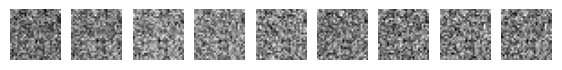

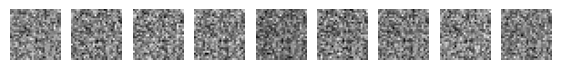

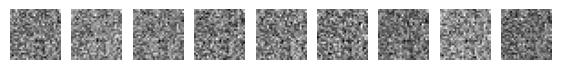

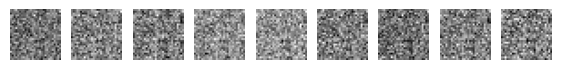

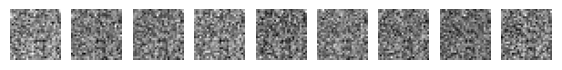

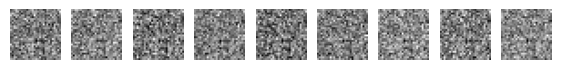

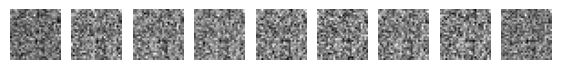

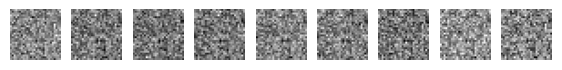

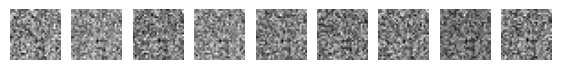

Epoch:0, Step:0, D-Loss:0.685, D-Acc:48.438, G-Loss:0.685
Epoch:0, Step:50, D-Loss:0.401, D-Acc:76.562, G-Loss:2.504
Epoch:0, Step:100, D-Loss:0.137, D-Acc:96.875, G-Loss:3.851
Epoch:0, Step:150, D-Loss:0.636, D-Acc:68.750, G-Loss:0.969
Epoch:1, Step:0, D-Loss:0.393, D-Acc:82.812, G-Loss:1.476
Epoch:1, Step:50, D-Loss:0.357, D-Acc:82.812, G-Loss:1.839
Epoch:1, Step:100, D-Loss:0.519, D-Acc:65.625, G-Loss:3.530
Epoch:1, Step:150, D-Loss:0.203, D-Acc:92.188, G-Loss:3.182
Epoch:2, Step:0, D-Loss:0.249, D-Acc:93.750, G-Loss:2.662
Epoch:2, Step:50, D-Loss:0.376, D-Acc:82.812, G-Loss:1.355
Epoch:2, Step:100, D-Loss:0.361, D-Acc:84.375, G-Loss:2.044
Epoch:2, Step:150, D-Loss:0.295, D-Acc:87.500, G-Loss:2.618
Epoch:3, Step:0, D-Loss:0.243, D-Acc:89.062, G-Loss:1.928
Epoch:3, Step:50, D-Loss:0.302, D-Acc:92.188, G-Loss:2.408
Epoch:3, Step:100, D-Loss:0.382, D-Acc:89.062, G-Loss:1.510
Epoch:3, Step:150, D-Loss:0.186, D-Acc:96.875, G-Loss:3.521
Epoch:4, Step:0, D-Loss:0.311, D-Acc:93.750, G-Loss:

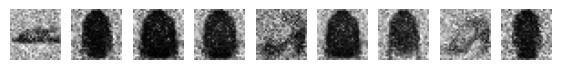

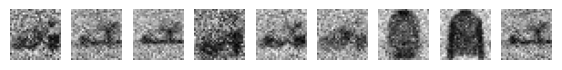

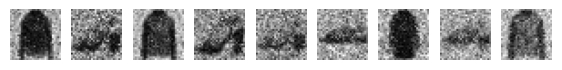

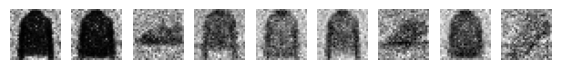

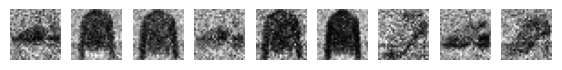

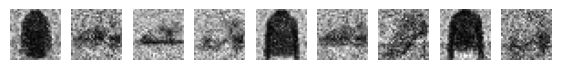

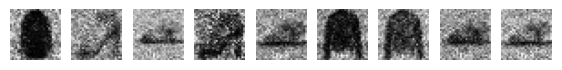

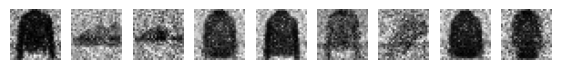

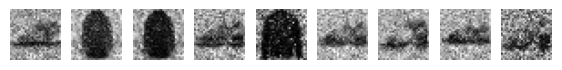

Epoch:10, Step:0, D-Loss:0.396, D-Acc:84.375, G-Loss:1.519
Epoch:10, Step:50, D-Loss:0.411, D-Acc:82.812, G-Loss:1.245
Epoch:10, Step:100, D-Loss:0.462, D-Acc:75.000, G-Loss:1.725
Epoch:10, Step:150, D-Loss:0.415, D-Acc:85.938, G-Loss:1.546
Epoch:11, Step:0, D-Loss:0.523, D-Acc:70.312, G-Loss:1.393
Epoch:11, Step:50, D-Loss:0.456, D-Acc:75.000, G-Loss:1.273
Epoch:11, Step:100, D-Loss:0.536, D-Acc:65.625, G-Loss:1.715
Epoch:11, Step:150, D-Loss:0.474, D-Acc:73.438, G-Loss:1.484
Epoch:12, Step:0, D-Loss:0.507, D-Acc:75.000, G-Loss:1.738
Epoch:12, Step:50, D-Loss:0.456, D-Acc:75.000, G-Loss:1.757
Epoch:12, Step:100, D-Loss:0.617, D-Acc:70.312, G-Loss:1.129
Epoch:12, Step:150, D-Loss:0.546, D-Acc:76.562, G-Loss:1.473
Epoch:13, Step:0, D-Loss:0.554, D-Acc:71.875, G-Loss:2.233
Epoch:13, Step:50, D-Loss:0.513, D-Acc:81.250, G-Loss:1.492
Epoch:13, Step:100, D-Loss:0.546, D-Acc:73.438, G-Loss:1.335
Epoch:13, Step:150, D-Loss:0.363, D-Acc:89.062, G-Loss:1.616
Epoch:14, Step:0, D-Loss:0.539, D-Ac

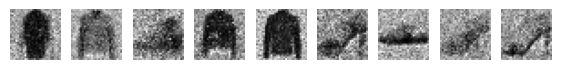

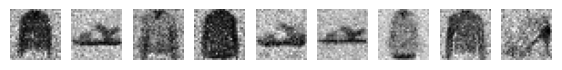

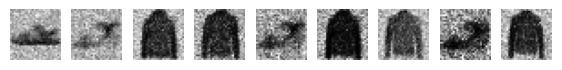

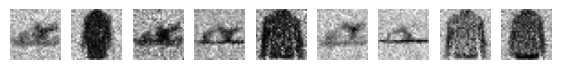

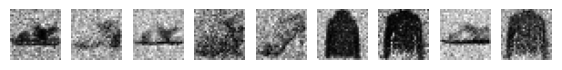

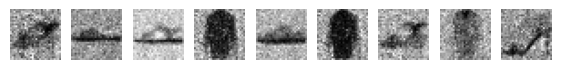

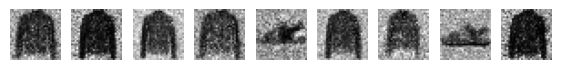

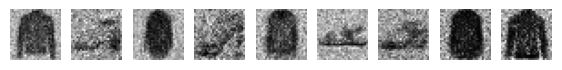

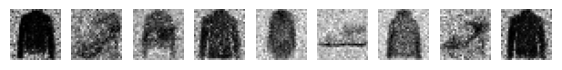

Epoch:20, Step:0, D-Loss:0.529, D-Acc:71.875, G-Loss:1.398
Epoch:20, Step:50, D-Loss:0.501, D-Acc:76.562, G-Loss:1.303
Epoch:20, Step:100, D-Loss:0.507, D-Acc:76.562, G-Loss:1.311
Epoch:20, Step:150, D-Loss:0.451, D-Acc:75.000, G-Loss:1.521
Epoch:21, Step:0, D-Loss:0.497, D-Acc:78.125, G-Loss:1.574
Epoch:21, Step:50, D-Loss:0.513, D-Acc:78.125, G-Loss:1.513
Epoch:21, Step:100, D-Loss:0.484, D-Acc:73.438, G-Loss:1.191
Epoch:21, Step:150, D-Loss:0.543, D-Acc:65.625, G-Loss:1.195
Epoch:22, Step:0, D-Loss:0.527, D-Acc:70.312, G-Loss:1.490
Epoch:22, Step:50, D-Loss:0.549, D-Acc:71.875, G-Loss:1.215
Epoch:22, Step:100, D-Loss:0.410, D-Acc:78.125, G-Loss:1.317
Epoch:22, Step:150, D-Loss:0.518, D-Acc:73.438, G-Loss:1.418
Epoch:23, Step:0, D-Loss:0.458, D-Acc:73.438, G-Loss:1.378
Epoch:23, Step:50, D-Loss:0.517, D-Acc:73.438, G-Loss:1.331
Epoch:23, Step:100, D-Loss:0.568, D-Acc:75.000, G-Loss:1.199
Epoch:23, Step:150, D-Loss:0.632, D-Acc:67.188, G-Loss:1.319
Epoch:24, Step:0, D-Loss:0.526, D-Ac

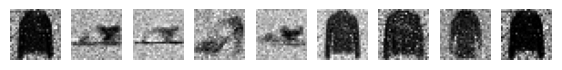

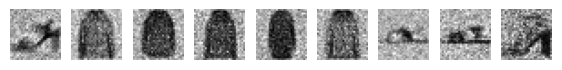

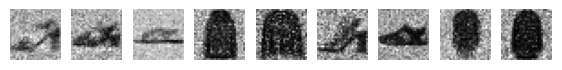

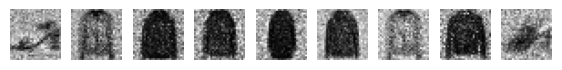

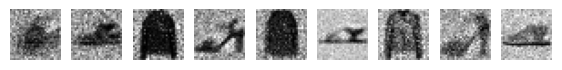

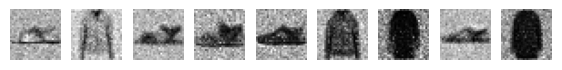

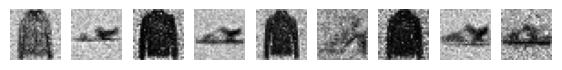

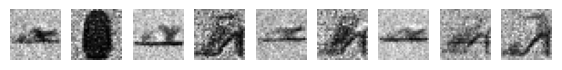

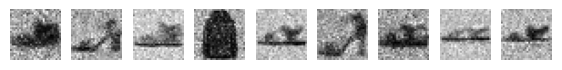

Epoch:30, Step:0, D-Loss:0.563, D-Acc:70.312, G-Loss:1.388
Epoch:30, Step:50, D-Loss:0.571, D-Acc:68.750, G-Loss:1.437
Epoch:30, Step:100, D-Loss:0.468, D-Acc:73.438, G-Loss:1.545
Epoch:30, Step:150, D-Loss:0.496, D-Acc:75.000, G-Loss:1.085
Epoch:31, Step:0, D-Loss:0.492, D-Acc:75.000, G-Loss:1.269
Epoch:31, Step:50, D-Loss:0.522, D-Acc:73.438, G-Loss:1.288
Epoch:31, Step:100, D-Loss:0.576, D-Acc:71.875, G-Loss:1.461
Epoch:31, Step:150, D-Loss:0.546, D-Acc:70.312, G-Loss:1.342
Epoch:32, Step:0, D-Loss:0.598, D-Acc:64.062, G-Loss:1.144
Epoch:32, Step:50, D-Loss:0.582, D-Acc:62.500, G-Loss:1.189
Epoch:32, Step:100, D-Loss:0.531, D-Acc:71.875, G-Loss:1.213
Epoch:32, Step:150, D-Loss:0.594, D-Acc:65.625, G-Loss:1.407
Epoch:33, Step:0, D-Loss:0.527, D-Acc:73.438, G-Loss:1.326
Epoch:33, Step:50, D-Loss:0.578, D-Acc:67.188, G-Loss:1.348
Epoch:33, Step:100, D-Loss:0.524, D-Acc:79.688, G-Loss:0.977
Epoch:33, Step:150, D-Loss:0.522, D-Acc:65.625, G-Loss:1.366
Epoch:34, Step:0, D-Loss:0.585, D-Ac

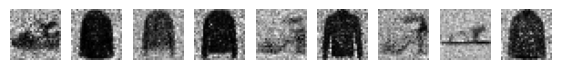

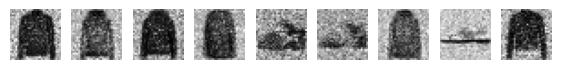

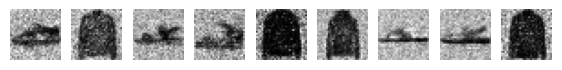

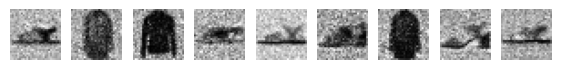

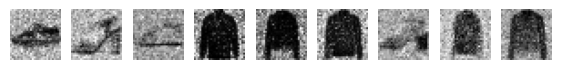

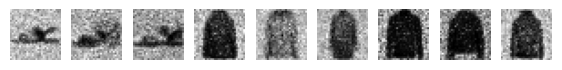

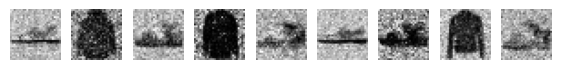

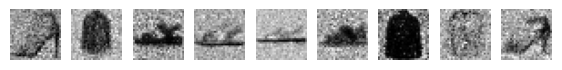

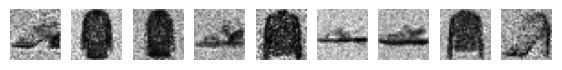

Epoch:40, Step:0, D-Loss:0.558, D-Acc:64.062, G-Loss:1.178
Epoch:40, Step:50, D-Loss:0.640, D-Acc:71.875, G-Loss:1.462
Epoch:40, Step:100, D-Loss:0.502, D-Acc:78.125, G-Loss:1.388
Epoch:40, Step:150, D-Loss:0.512, D-Acc:75.000, G-Loss:1.268
Epoch:41, Step:0, D-Loss:0.518, D-Acc:68.750, G-Loss:1.441
Epoch:41, Step:50, D-Loss:0.578, D-Acc:65.625, G-Loss:1.158
Epoch:41, Step:100, D-Loss:0.545, D-Acc:68.750, G-Loss:1.191
Epoch:41, Step:150, D-Loss:0.496, D-Acc:81.250, G-Loss:1.654
Epoch:42, Step:0, D-Loss:0.478, D-Acc:79.688, G-Loss:1.352
Epoch:42, Step:50, D-Loss:0.556, D-Acc:71.875, G-Loss:1.246
Epoch:42, Step:100, D-Loss:0.536, D-Acc:79.688, G-Loss:1.445
Epoch:42, Step:150, D-Loss:0.472, D-Acc:75.000, G-Loss:1.227
Epoch:43, Step:0, D-Loss:0.667, D-Acc:65.625, G-Loss:1.167
Epoch:43, Step:50, D-Loss:0.502, D-Acc:70.312, G-Loss:1.234
Epoch:43, Step:100, D-Loss:0.481, D-Acc:73.438, G-Loss:1.201
Epoch:43, Step:150, D-Loss:0.553, D-Acc:76.562, G-Loss:1.076
Epoch:44, Step:0, D-Loss:0.425, D-Ac

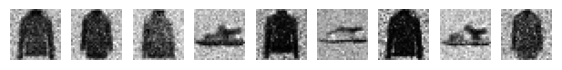

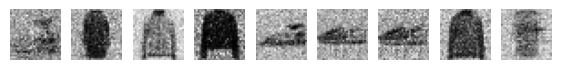

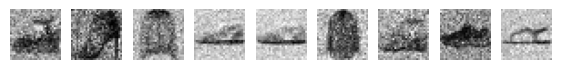

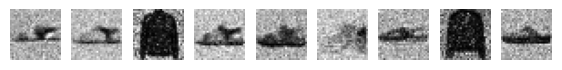

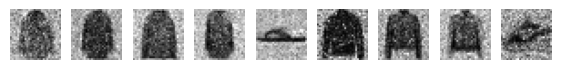

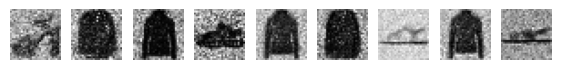

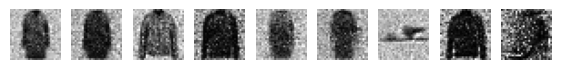

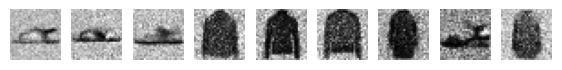

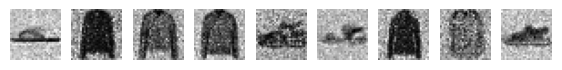

Epoch:50, Step:0, D-Loss:0.481, D-Acc:82.812, G-Loss:1.407
Epoch:50, Step:50, D-Loss:0.476, D-Acc:71.875, G-Loss:1.210
Epoch:50, Step:100, D-Loss:0.458, D-Acc:78.125, G-Loss:1.348
Epoch:50, Step:150, D-Loss:0.431, D-Acc:78.125, G-Loss:1.290
Epoch:51, Step:0, D-Loss:0.481, D-Acc:75.000, G-Loss:1.283
Epoch:51, Step:50, D-Loss:0.501, D-Acc:67.188, G-Loss:1.310
Epoch:51, Step:100, D-Loss:0.464, D-Acc:75.000, G-Loss:1.262
Epoch:51, Step:150, D-Loss:0.657, D-Acc:59.375, G-Loss:1.054
Epoch:52, Step:0, D-Loss:0.585, D-Acc:67.188, G-Loss:1.324
Epoch:52, Step:50, D-Loss:0.604, D-Acc:67.188, G-Loss:1.339
Epoch:52, Step:100, D-Loss:0.546, D-Acc:71.875, G-Loss:1.433
Epoch:52, Step:150, D-Loss:0.542, D-Acc:68.750, G-Loss:1.747
Epoch:53, Step:0, D-Loss:0.549, D-Acc:75.000, G-Loss:1.630
Epoch:53, Step:50, D-Loss:0.510, D-Acc:73.438, G-Loss:1.660
Epoch:53, Step:100, D-Loss:0.493, D-Acc:81.250, G-Loss:1.418
Epoch:53, Step:150, D-Loss:0.523, D-Acc:65.625, G-Loss:1.525
Epoch:54, Step:0, D-Loss:0.488, D-Ac

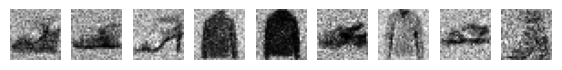

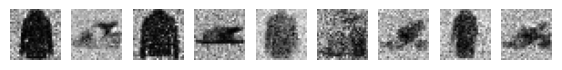

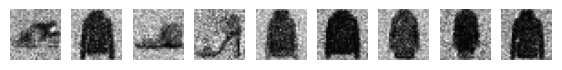

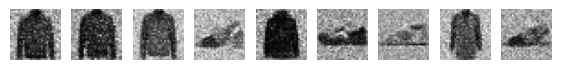

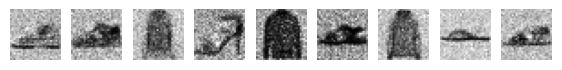

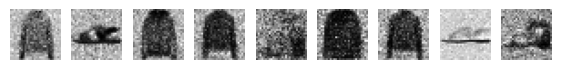

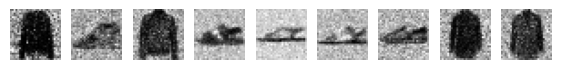

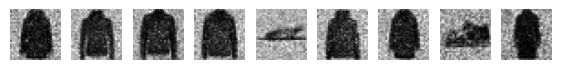

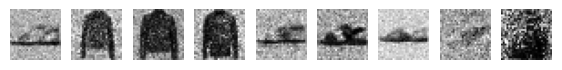

Epoch:60, Step:0, D-Loss:0.548, D-Acc:75.000, G-Loss:1.709
Epoch:60, Step:50, D-Loss:0.569, D-Acc:70.312, G-Loss:1.267
Epoch:60, Step:100, D-Loss:0.466, D-Acc:81.250, G-Loss:1.276
Epoch:60, Step:150, D-Loss:0.525, D-Acc:84.375, G-Loss:1.213
Epoch:61, Step:0, D-Loss:0.612, D-Acc:62.500, G-Loss:1.751
Epoch:61, Step:50, D-Loss:0.439, D-Acc:73.438, G-Loss:1.525
Epoch:61, Step:100, D-Loss:0.522, D-Acc:68.750, G-Loss:1.251
Epoch:61, Step:150, D-Loss:0.440, D-Acc:81.250, G-Loss:1.125
Epoch:62, Step:0, D-Loss:0.504, D-Acc:73.438, G-Loss:1.514
Epoch:62, Step:50, D-Loss:0.488, D-Acc:76.562, G-Loss:1.516
Epoch:62, Step:100, D-Loss:0.466, D-Acc:78.125, G-Loss:1.589
Epoch:62, Step:150, D-Loss:0.421, D-Acc:82.812, G-Loss:1.589
Epoch:63, Step:0, D-Loss:0.473, D-Acc:75.000, G-Loss:1.531
Epoch:63, Step:50, D-Loss:0.467, D-Acc:81.250, G-Loss:1.376
Epoch:63, Step:100, D-Loss:0.506, D-Acc:82.812, G-Loss:1.631
Epoch:63, Step:150, D-Loss:0.468, D-Acc:76.562, G-Loss:1.334
Epoch:64, Step:0, D-Loss:0.485, D-Ac

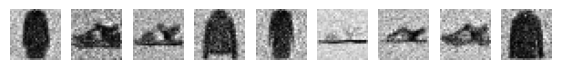

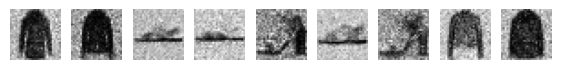

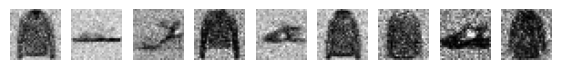

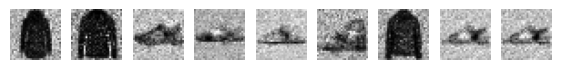

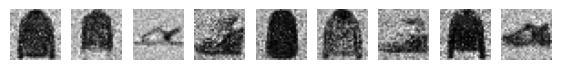

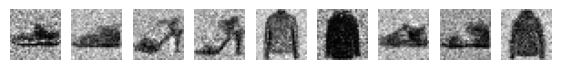

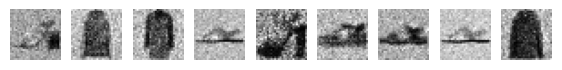

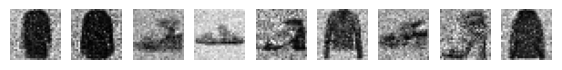

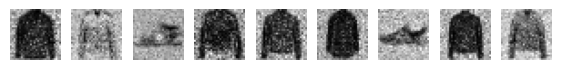

Epoch:70, Step:0, D-Loss:0.311, D-Acc:85.938, G-Loss:1.795
Epoch:70, Step:50, D-Loss:0.519, D-Acc:70.312, G-Loss:1.460
Epoch:70, Step:100, D-Loss:0.494, D-Acc:78.125, G-Loss:1.814
Epoch:70, Step:150, D-Loss:0.455, D-Acc:78.125, G-Loss:1.448
Epoch:71, Step:0, D-Loss:0.432, D-Acc:78.125, G-Loss:1.739
Epoch:71, Step:50, D-Loss:0.554, D-Acc:75.000, G-Loss:1.668
Epoch:71, Step:100, D-Loss:0.497, D-Acc:71.875, G-Loss:1.935
Epoch:71, Step:150, D-Loss:0.543, D-Acc:68.750, G-Loss:1.784
Epoch:72, Step:0, D-Loss:0.466, D-Acc:75.000, G-Loss:1.530
Epoch:72, Step:50, D-Loss:0.502, D-Acc:76.562, G-Loss:1.578
Epoch:72, Step:100, D-Loss:0.521, D-Acc:79.688, G-Loss:2.038
Epoch:72, Step:150, D-Loss:0.508, D-Acc:73.438, G-Loss:1.446
Epoch:73, Step:0, D-Loss:0.413, D-Acc:78.125, G-Loss:1.889
Epoch:73, Step:50, D-Loss:0.427, D-Acc:84.375, G-Loss:1.576
Epoch:73, Step:100, D-Loss:0.409, D-Acc:75.000, G-Loss:1.676
Epoch:73, Step:150, D-Loss:0.354, D-Acc:84.375, G-Loss:1.572
Epoch:74, Step:0, D-Loss:0.508, D-Ac

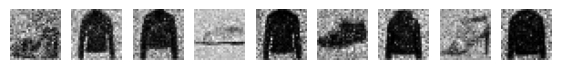

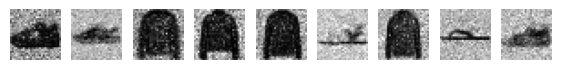

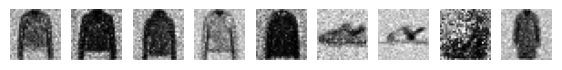

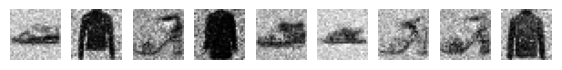

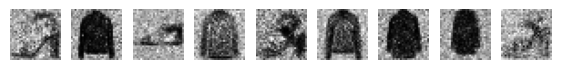

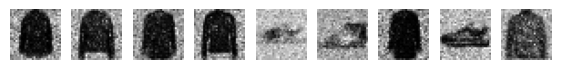

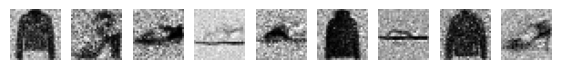

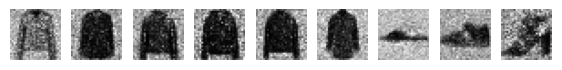

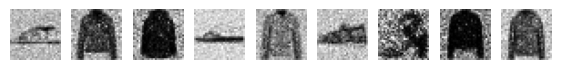

Epoch:80, Step:0, D-Loss:0.519, D-Acc:73.438, G-Loss:2.045
Epoch:80, Step:50, D-Loss:0.387, D-Acc:82.812, G-Loss:1.830
Epoch:80, Step:100, D-Loss:0.363, D-Acc:82.812, G-Loss:1.588
Epoch:80, Step:150, D-Loss:0.366, D-Acc:78.125, G-Loss:1.893
Epoch:81, Step:0, D-Loss:0.429, D-Acc:78.125, G-Loss:2.005
Epoch:81, Step:50, D-Loss:0.424, D-Acc:78.125, G-Loss:1.793
Epoch:81, Step:100, D-Loss:0.535, D-Acc:76.562, G-Loss:1.528
Epoch:81, Step:150, D-Loss:0.424, D-Acc:84.375, G-Loss:2.259
Epoch:82, Step:0, D-Loss:0.408, D-Acc:79.688, G-Loss:1.805
Epoch:82, Step:50, D-Loss:0.500, D-Acc:78.125, G-Loss:1.646
Epoch:82, Step:100, D-Loss:0.385, D-Acc:84.375, G-Loss:1.380
Epoch:82, Step:150, D-Loss:0.462, D-Acc:76.562, G-Loss:1.746
Epoch:83, Step:0, D-Loss:0.468, D-Acc:78.125, G-Loss:1.889
Epoch:83, Step:50, D-Loss:0.491, D-Acc:73.438, G-Loss:1.669
Epoch:83, Step:100, D-Loss:0.349, D-Acc:85.938, G-Loss:1.663
Epoch:83, Step:150, D-Loss:0.464, D-Acc:76.562, G-Loss:1.681
Epoch:84, Step:0, D-Loss:0.497, D-Ac

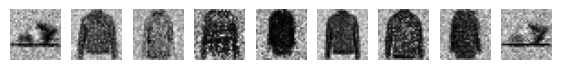

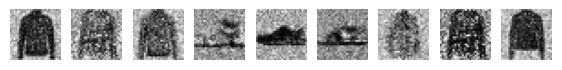

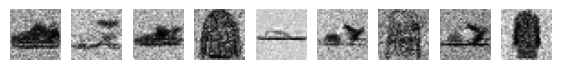

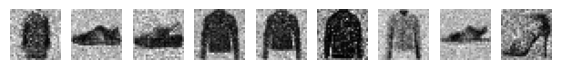

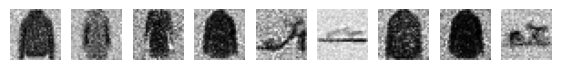

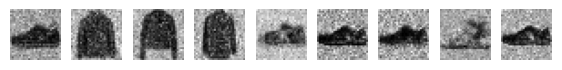

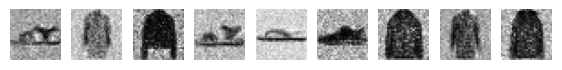

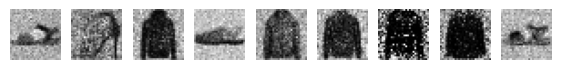

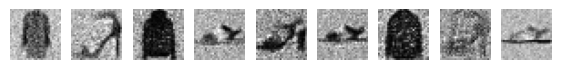

Epoch:90, Step:0, D-Loss:0.490, D-Acc:75.000, G-Loss:2.293
Epoch:90, Step:50, D-Loss:0.445, D-Acc:78.125, G-Loss:1.954
Epoch:90, Step:100, D-Loss:0.298, D-Acc:85.938, G-Loss:2.103
Epoch:90, Step:150, D-Loss:0.430, D-Acc:75.000, G-Loss:1.967
Epoch:91, Step:0, D-Loss:0.361, D-Acc:78.125, G-Loss:2.035
Epoch:91, Step:50, D-Loss:0.420, D-Acc:75.000, G-Loss:1.798
Epoch:91, Step:100, D-Loss:0.509, D-Acc:70.312, G-Loss:1.922
Epoch:91, Step:150, D-Loss:0.343, D-Acc:79.688, G-Loss:2.235
Epoch:92, Step:0, D-Loss:0.405, D-Acc:79.688, G-Loss:2.081
Epoch:92, Step:50, D-Loss:0.421, D-Acc:81.250, G-Loss:2.232
Epoch:92, Step:100, D-Loss:0.260, D-Acc:85.938, G-Loss:2.158
Epoch:92, Step:150, D-Loss:0.386, D-Acc:82.812, G-Loss:2.168
Epoch:93, Step:0, D-Loss:0.377, D-Acc:79.688, G-Loss:1.905
Epoch:93, Step:50, D-Loss:0.392, D-Acc:79.688, G-Loss:2.453
Epoch:93, Step:100, D-Loss:0.412, D-Acc:82.812, G-Loss:1.948
Epoch:93, Step:150, D-Loss:0.335, D-Acc:82.812, G-Loss:2.170
Epoch:94, Step:0, D-Loss:0.299, D-Ac

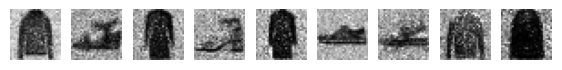

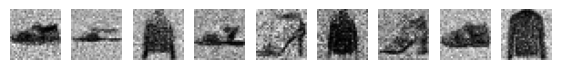

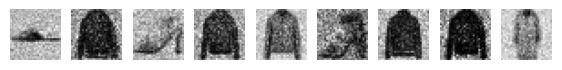

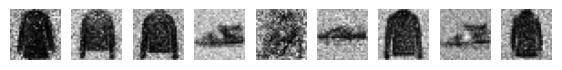

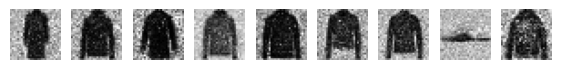

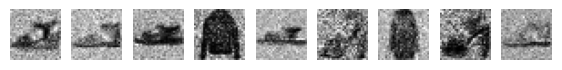

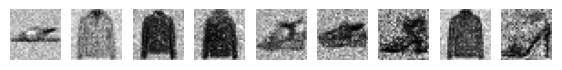

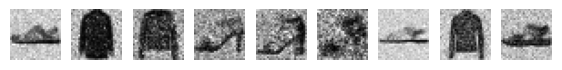

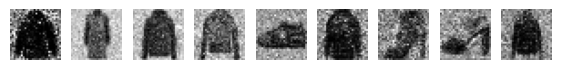

Epoch:100, Step:0, D-Loss:0.338, D-Acc:79.688, G-Loss:2.325
Epoch:100, Step:50, D-Loss:0.504, D-Acc:79.688, G-Loss:2.024
Epoch:100, Step:100, D-Loss:0.351, D-Acc:84.375, G-Loss:2.148
Epoch:100, Step:150, D-Loss:0.339, D-Acc:79.688, G-Loss:2.277
Epoch:101, Step:0, D-Loss:0.396, D-Acc:79.688, G-Loss:2.154
Epoch:101, Step:50, D-Loss:0.366, D-Acc:84.375, G-Loss:2.227
Epoch:101, Step:100, D-Loss:0.435, D-Acc:79.688, G-Loss:1.859
Epoch:101, Step:150, D-Loss:0.311, D-Acc:85.938, G-Loss:1.763
Epoch:102, Step:0, D-Loss:0.424, D-Acc:78.125, G-Loss:1.957
Epoch:102, Step:50, D-Loss:0.332, D-Acc:81.250, G-Loss:2.083
Epoch:102, Step:100, D-Loss:0.294, D-Acc:87.500, G-Loss:2.193
Epoch:102, Step:150, D-Loss:0.565, D-Acc:70.312, G-Loss:1.957
Epoch:103, Step:0, D-Loss:0.369, D-Acc:82.812, G-Loss:2.010
Epoch:103, Step:50, D-Loss:0.288, D-Acc:87.500, G-Loss:2.036
Epoch:103, Step:100, D-Loss:0.427, D-Acc:76.562, G-Loss:1.983
Epoch:103, Step:150, D-Loss:0.378, D-Acc:87.500, G-Loss:2.218
Epoch:104, Step:0, D

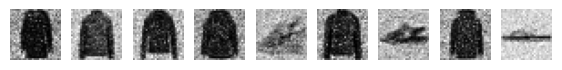

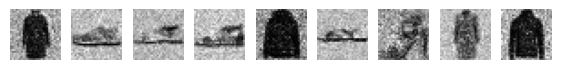

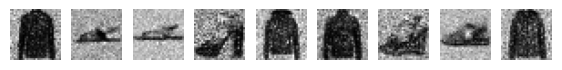

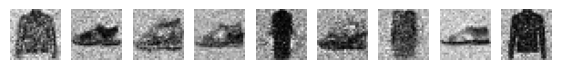

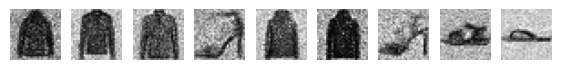

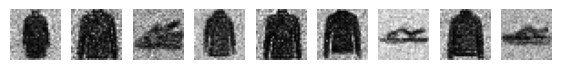

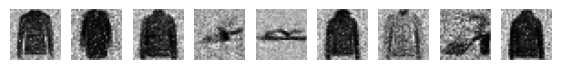

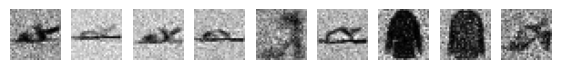

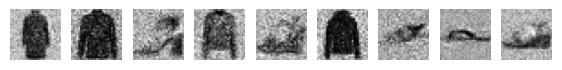

Epoch:110, Step:0, D-Loss:0.400, D-Acc:81.250, G-Loss:2.045
Epoch:110, Step:50, D-Loss:0.361, D-Acc:82.812, G-Loss:2.154
Epoch:110, Step:100, D-Loss:0.430, D-Acc:71.875, G-Loss:2.105
Epoch:110, Step:150, D-Loss:0.371, D-Acc:82.812, G-Loss:2.122
Epoch:111, Step:0, D-Loss:0.477, D-Acc:73.438, G-Loss:2.577
Epoch:111, Step:50, D-Loss:0.444, D-Acc:82.812, G-Loss:2.026
Epoch:111, Step:100, D-Loss:0.366, D-Acc:79.688, G-Loss:2.235
Epoch:111, Step:150, D-Loss:0.259, D-Acc:87.500, G-Loss:2.263
Epoch:112, Step:0, D-Loss:0.315, D-Acc:82.812, G-Loss:2.216
Epoch:112, Step:50, D-Loss:0.444, D-Acc:79.688, G-Loss:2.312
Epoch:112, Step:100, D-Loss:0.424, D-Acc:89.062, G-Loss:2.673
Epoch:112, Step:150, D-Loss:0.392, D-Acc:85.938, G-Loss:2.343
Epoch:113, Step:0, D-Loss:0.531, D-Acc:67.188, G-Loss:1.933
Epoch:113, Step:50, D-Loss:0.351, D-Acc:84.375, G-Loss:2.598
Epoch:113, Step:100, D-Loss:0.333, D-Acc:89.062, G-Loss:2.091
Epoch:113, Step:150, D-Loss:0.468, D-Acc:73.438, G-Loss:2.297
Epoch:114, Step:0, D

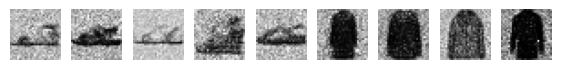

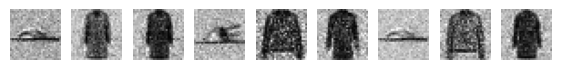

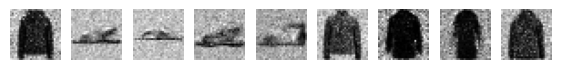

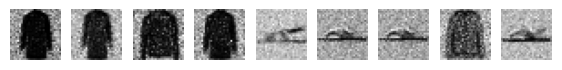

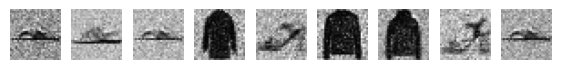

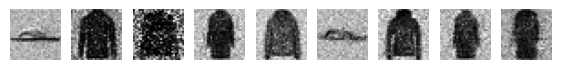

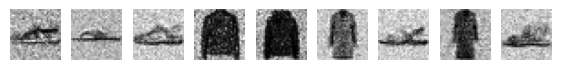

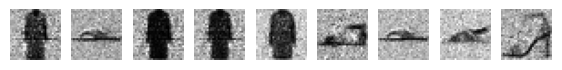

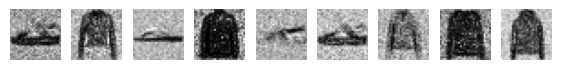

Epoch:120, Step:0, D-Loss:0.428, D-Acc:78.125, G-Loss:2.494
Epoch:120, Step:50, D-Loss:0.398, D-Acc:75.000, G-Loss:2.248
Epoch:120, Step:100, D-Loss:0.297, D-Acc:85.938, G-Loss:2.353
Epoch:120, Step:150, D-Loss:0.293, D-Acc:84.375, G-Loss:2.637
Epoch:121, Step:0, D-Loss:0.430, D-Acc:81.250, G-Loss:2.644
Epoch:121, Step:50, D-Loss:0.323, D-Acc:82.812, G-Loss:2.734
Epoch:121, Step:100, D-Loss:0.439, D-Acc:84.375, G-Loss:2.087
Epoch:121, Step:150, D-Loss:0.465, D-Acc:75.000, G-Loss:2.347
Epoch:122, Step:0, D-Loss:0.338, D-Acc:87.500, G-Loss:2.351
Epoch:122, Step:50, D-Loss:0.416, D-Acc:75.000, G-Loss:2.089
Epoch:122, Step:100, D-Loss:0.407, D-Acc:71.875, G-Loss:2.110
Epoch:122, Step:150, D-Loss:0.338, D-Acc:82.812, G-Loss:2.979
Epoch:123, Step:0, D-Loss:0.363, D-Acc:84.375, G-Loss:1.999
Epoch:123, Step:50, D-Loss:0.406, D-Acc:79.688, G-Loss:1.828
Epoch:123, Step:100, D-Loss:0.445, D-Acc:75.000, G-Loss:2.475
Epoch:123, Step:150, D-Loss:0.302, D-Acc:87.500, G-Loss:1.995
Epoch:124, Step:0, D

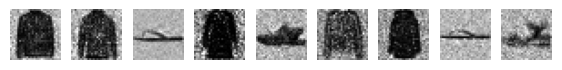

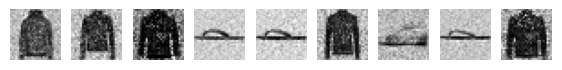

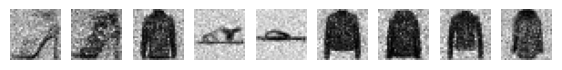

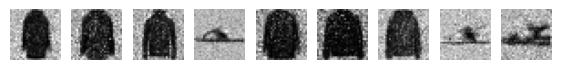

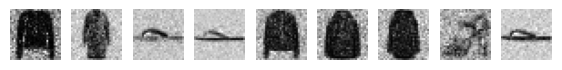

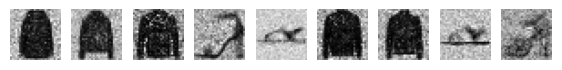

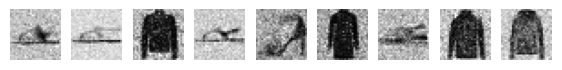

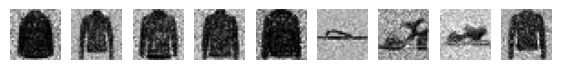

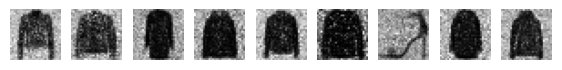

Epoch:130, Step:0, D-Loss:0.318, D-Acc:89.062, G-Loss:2.380
Epoch:130, Step:50, D-Loss:0.367, D-Acc:84.375, G-Loss:2.342
Epoch:130, Step:100, D-Loss:0.223, D-Acc:95.312, G-Loss:2.604
Epoch:130, Step:150, D-Loss:0.382, D-Acc:87.500, G-Loss:2.434
Epoch:131, Step:0, D-Loss:0.266, D-Acc:89.062, G-Loss:2.546
Epoch:131, Step:50, D-Loss:0.328, D-Acc:78.125, G-Loss:2.939
Epoch:131, Step:100, D-Loss:0.301, D-Acc:90.625, G-Loss:2.360
Epoch:131, Step:150, D-Loss:0.281, D-Acc:85.938, G-Loss:2.350
Epoch:132, Step:0, D-Loss:0.282, D-Acc:85.938, G-Loss:2.056
Epoch:132, Step:50, D-Loss:0.208, D-Acc:90.625, G-Loss:2.668
Epoch:132, Step:100, D-Loss:0.328, D-Acc:84.375, G-Loss:2.508
Epoch:132, Step:150, D-Loss:0.324, D-Acc:81.250, G-Loss:2.612
Epoch:133, Step:0, D-Loss:0.324, D-Acc:89.062, G-Loss:2.668
Epoch:133, Step:50, D-Loss:0.372, D-Acc:79.688, G-Loss:2.257
Epoch:133, Step:100, D-Loss:0.327, D-Acc:79.688, G-Loss:2.633
Epoch:133, Step:150, D-Loss:0.290, D-Acc:85.938, G-Loss:3.047
Epoch:134, Step:0, D

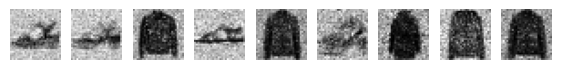

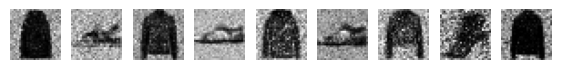

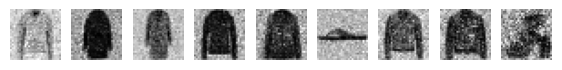

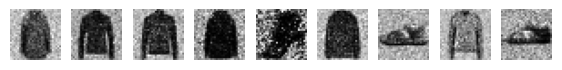

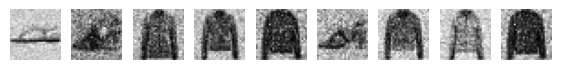

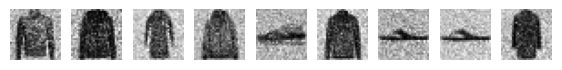

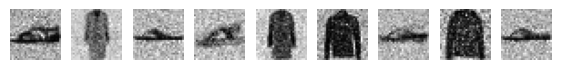

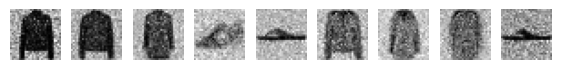

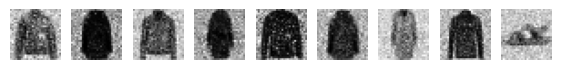

Epoch:140, Step:0, D-Loss:0.374, D-Acc:76.562, G-Loss:2.853
Epoch:140, Step:50, D-Loss:0.253, D-Acc:89.062, G-Loss:3.488
Epoch:140, Step:100, D-Loss:0.285, D-Acc:81.250, G-Loss:2.724
Epoch:140, Step:150, D-Loss:0.274, D-Acc:85.938, G-Loss:3.245
Epoch:141, Step:0, D-Loss:0.343, D-Acc:79.688, G-Loss:2.402
Epoch:141, Step:50, D-Loss:0.367, D-Acc:84.375, G-Loss:2.596
Epoch:141, Step:100, D-Loss:0.436, D-Acc:76.562, G-Loss:2.764
Epoch:141, Step:150, D-Loss:0.450, D-Acc:78.125, G-Loss:2.982
Epoch:142, Step:0, D-Loss:0.390, D-Acc:82.812, G-Loss:2.007
Epoch:142, Step:50, D-Loss:0.427, D-Acc:76.562, G-Loss:3.056
Epoch:142, Step:100, D-Loss:0.243, D-Acc:89.062, G-Loss:3.912
Epoch:142, Step:150, D-Loss:0.283, D-Acc:89.062, G-Loss:3.060
Epoch:143, Step:0, D-Loss:0.239, D-Acc:89.062, G-Loss:2.281
Epoch:143, Step:50, D-Loss:0.244, D-Acc:90.625, G-Loss:2.631
Epoch:143, Step:100, D-Loss:0.384, D-Acc:79.688, G-Loss:3.298
Epoch:143, Step:150, D-Loss:0.235, D-Acc:89.062, G-Loss:2.597
Epoch:144, Step:0, D

In [ ]:
epochs = 150
batch_size = 64
steps = 187
noise_size = 100

losses_d = []
losses_g = []

for i in range(0, epochs):
    if (i % 10 == 0):
        show_generator_results(generator_network)
    for j in range(steps):
        fake_samples, fake_labels = get_fake_samples(generator_network, batch_size // 2, noise_size)
        real_samples, real_labels = get_real_samples(batch_size=batch_size // 2)

        fake_y = np.zeros((batch_size // 2, 1))
        real_y = np.ones((batch_size // 2, 1))

        input_batch = np.vstack((fake_samples, real_samples))
        label_batch = np.vstack((fake_labels, real_labels))
        output_labels = np.vstack((fake_y, real_y))

        discriminator_network.trainable = True
        loss_d = discriminator_network.train_on_batch([input_batch, label_batch], output_labels)

        gan_input = get_random_noise(batch_size, noise_size)
        gan_labels = get_random_labels(batch_size)
        gan_output = np.ones((batch_size, 1))

        discriminator_network.trainable = False
        loss_g = gan_model.train_on_batch([gan_input, gan_labels], gan_output)

        losses_d.append(loss_d[0])
        losses_g.append(loss_g)

        if j % 50 == 0:
            print("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f" % (i, j, loss_d[0], loss_d[1] * 100, loss_g))

Function untuk menghitung score Fréchet Inception Distance (FID) dimana diawal image real dan fake akan di reshape menjadi 2D array dimana setiap row merepresentasikan versi image yang di flatten. Selanjutnya Mean dan Covariance dari image real dan fake akan di hitung untuk mencari squared difference dan covariance mean dari image real dan fake, lalu keduanya akan digunakan untuk menghitung nilai FID.

In [ ]:
import numpy as np
from scipy.linalg import sqrtm

def generate_fid(realimg, fakeimg):
  realimg = realimg.reshape((realimg.shape[0], -1))
  fakeimg = fakeimg.reshape((fakeimg.shape[0], -1))

  mu_real = np.mean(realimg, axis=0)
  sigma_real = np.cov(realimg, rowvar=False)
  mu_fake = np.mean(fakeimg, axis=0)
  sigma_fake = np.cov(fakeimg, rowvar=False)

  ssdiff = np.sum((mu_real - mu_fake) ** 2.0)
  cmean = sqrtm(sigma_real.dot(sigma_fake))

  if np.iscomplexobj(cmean):
    cmean = cmean.real

  fid_score = ssdiff + np.trace(sigma_real + sigma_fake - 2.0 * cmean)

  return fid_score

untuk melihat score FID kepada test data, pertama-tama akan di generate random noise sample untuk digenerate menjadi fake image lalu fake image akan di generate menggunakan model generator dengan input noise yang sudah di generate dan juga label dari test data.

In [ ]:
noise = np.random.normal(0, 1, (xtest.shape[0], 100))
fake_label = y_test_filtered
fake_image = generator_network.predict([noise, fake_label])

63/63 [==============================] - 0s 2ms/step


Setelah image sudah di generate, hasil skor FID yang didapat adalah 20.1178

In [ ]:
fidscore = generate_fid(xtest, fake_image)
print(f'FID Score: {fidscore}')

FID Score: 20.11786312181283


Terakhir, image real dan image fake akan dibandingkan. Image fake masih bisa menyerupai image real walaupun tidak sebagus image real dan masih banyak noice. Ini menandakan model masih bisa ditingkatkan untuk mengenerate fake image yang lebih menyerupai real image.

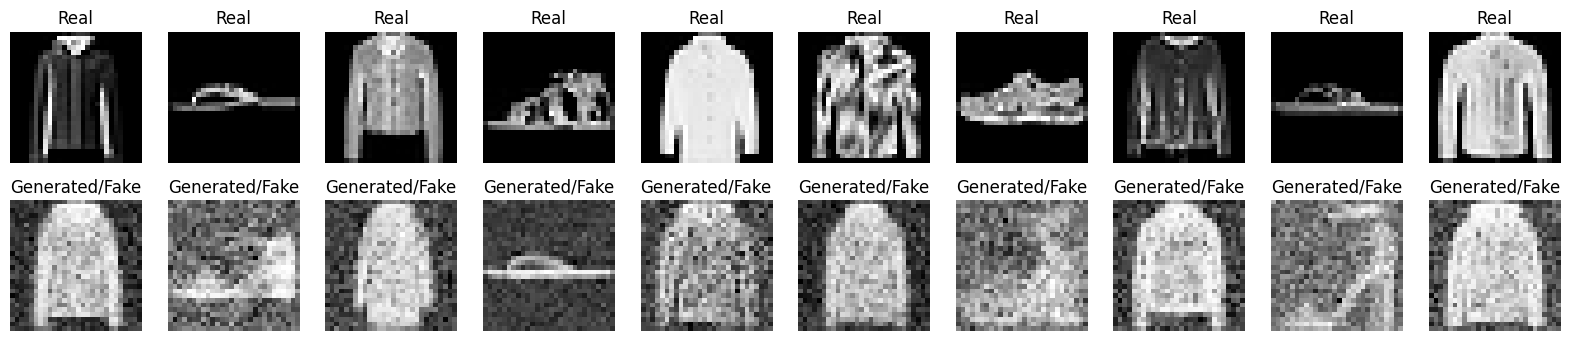

In [ ]:
def compare_img(real_images, generated_images, num_img = 10):
    num_img = min(num_img, real_images.shape[0], generated_images.shape[0])

    plt.figure(figsize = (20, 4))
    for i in range(num_img):

        plt.subplot(2, num_img, i + 1)
        plt.imshow(real_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
        plt.title("Real")

        plt.subplot(2, num_img, num_img + i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
        plt.title("Generated/Fake")

    plt.show()

compare_img(xtest, fake_image, num_img = 10)

LINK VIDEO PENJELASAN: https://binusianorg-my.sharepoint.com/personal/brandon_yang_binus_ac_id/_layouts/15/guestaccess.aspx?share=ETAylvNiZWhDkK2SbATkLSABHCvC4b6FgJYHzlcqmSQ1LA&nav=eyJyZWZlcnJhbEluZm8iOnsicmVmZXJyYWxBcHAiOiJPbmVEcml2ZUZvckJ1c2luZXNzIiwicmVmZXJyYWxBcHBQbGF0Zm9ybSI6IldlYiIsInJlZmVycmFsTW9kZSI6InZpZXciLCJyZWZlcnJhbFZpZXciOiJNeUZpbGVzTGlua0NvcHkifX0&e=toBqBv